In [1]:
import os
import tensorflow as tf
import numpy as np
from galaxy2galaxy import problems
import matplotlib.pyplot as plt
from absl import flags, app

In [2]:
sigma_noise = 23.59

def pre_proc_unet(dico):
    r"""Preprocess the data and apply the Tikhonov filter on the input galaxy images.

    This function takes the dictionnary of galaxy images and PSF for the input and
    the target and returns a list containing 2 arrays: an array of galaxy images that
    are the output of the Tikhonov filter and an array of target galaxy images.

    Parameters
    ----------
    dico : dictionnary
        Array_like means all those objects -- lists, nested lists, etc. --
        that can be converted to an array.  We can also refer to
        variables like `var1`.
     
    Returns
    -------
    list
        list containing 2 arrays: an array of galaxy images that are the output of the
        Tikhonov filter and an array of target galaxy images.
    
    Example
    -------
    These are written in doctest format, and should illustrate how to
    use the function.

    >>> from galaxy2galaxy import problems # to list avaible problems run problems.available()
    >>> problem128 = problems.problem('attrs2img_cosmos_hst2euclide')
    >>> dset = problem128.dataset(Modes.TRAIN, data_dir='attrs2img_cosmos_hst2euclide')
    >>> dset = dset.map(pre_proc_unet)
    """
    # Add noise
    # For the estimation of CFHT noise standard deviation check section 3 of:
    # https://github.com/CosmoStat/ShapeDeconv/blob/master/data/CFHT/HST2CFHT.ipynb
    
    sigma_cfht = sigma_noise
    noise = tf.random_normal(shape=tf.shape(dico['inputs']), mean=0.0, stddev=sigma_cfht, dtype=tf.float32)
    dico['inputs'] = dico['targets'] + noise

    return dico['inputs'], dico['targets']

In [3]:
# Let's create an instance of the hsc_problem
Modes = tf.estimator.ModeKeys
problem128 = problems.problem('attrs2img_cosmos_cfht2hst')
dset = problem128.dataset(Modes.TRAIN, data_dir='/local/home/ua264756/Data/attrs2img_cosmos_cfht2hst')
dset = dset.repeat()
dset = dset.map(pre_proc_unet)
n_batch = 32
dset = dset.batch(n_batch)

# Build an iterator over the dataset
iterator = dset.make_one_shot_iterator().get_next()

sess = tf.Session()

# Initialize batch
batch = sess.run(iterator) 


INFO:tensorflow:Reading data files from /local/home/ua264756/Data/attrs2img_cosmos_cfht2hst/attrs2img_cosmos_cfht2hst-train*
INFO:tensorflow:partition: 0 num_data_files: 49
Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.experimental.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_determinstic`.

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.


Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_

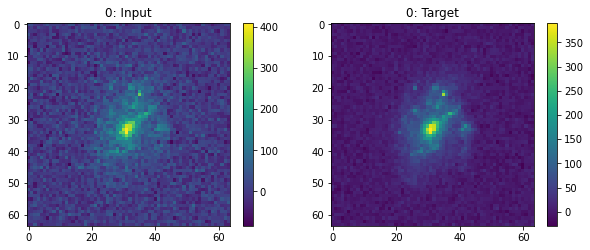

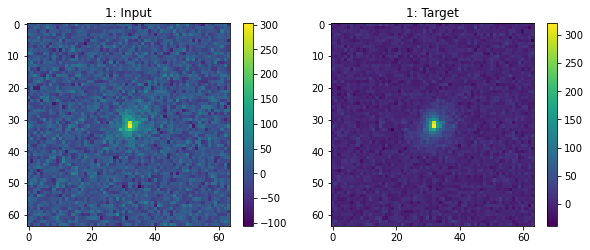

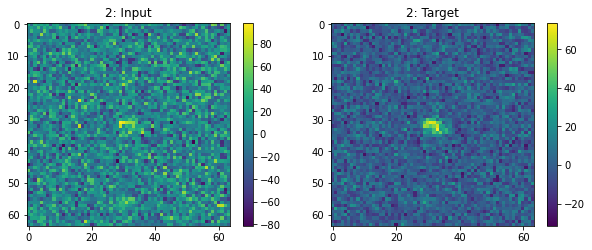

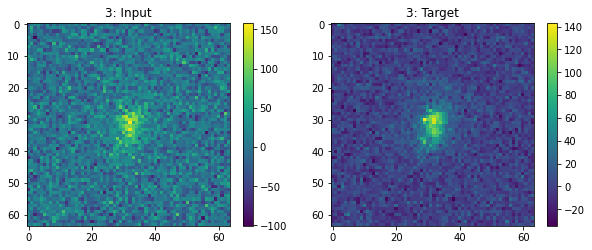

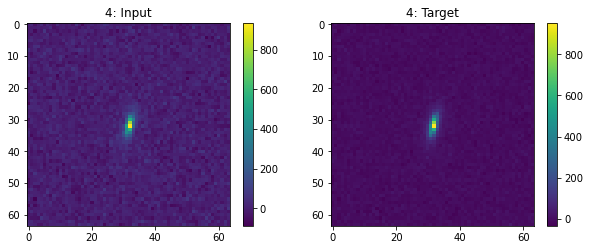

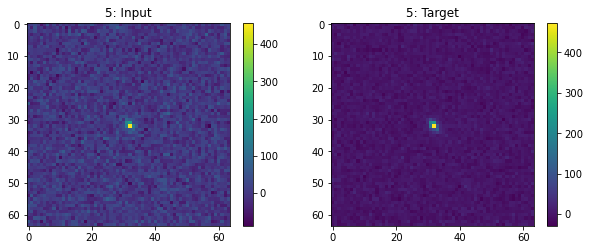

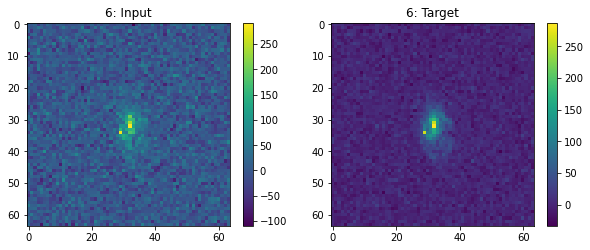

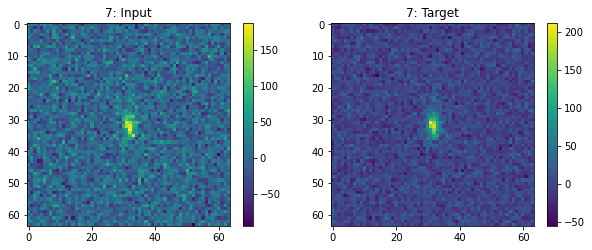

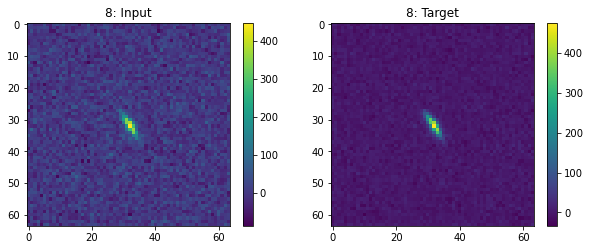

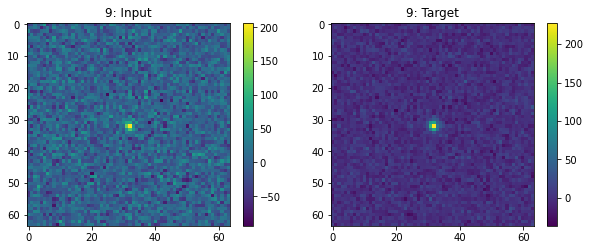

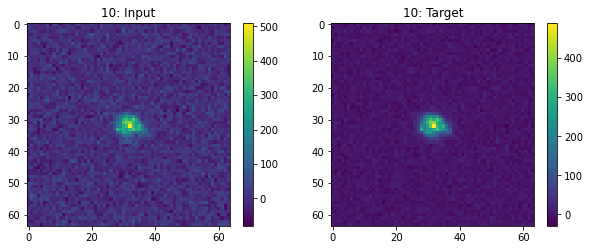

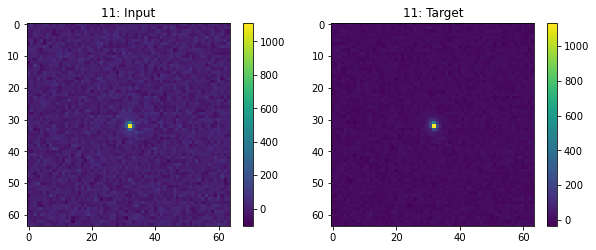

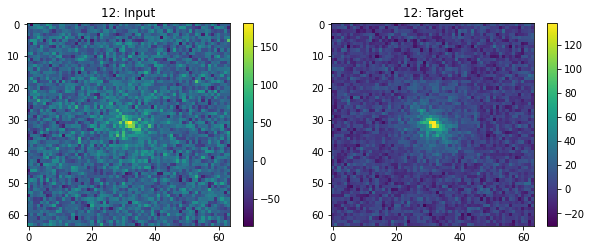

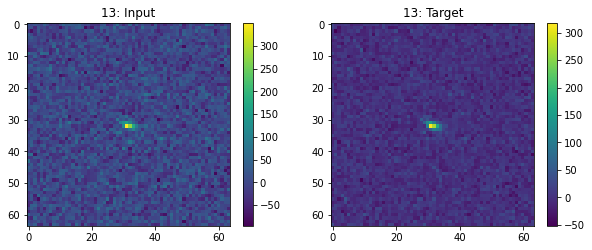

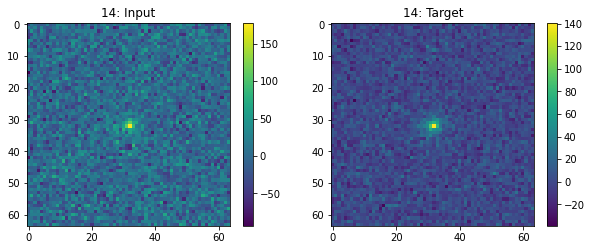

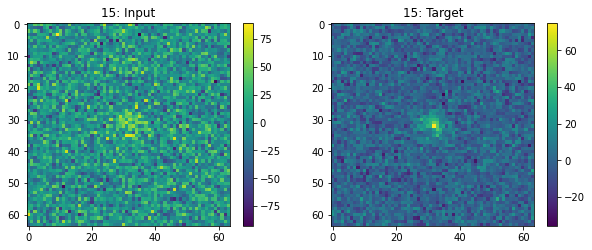

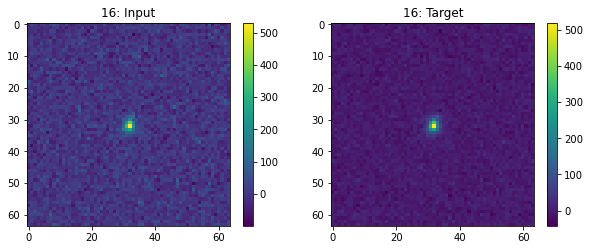

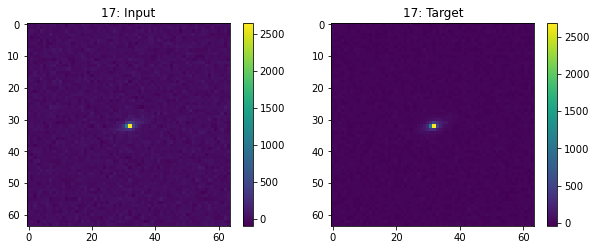

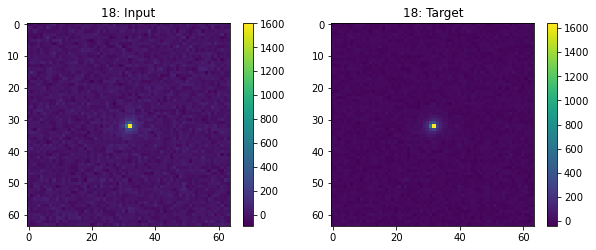

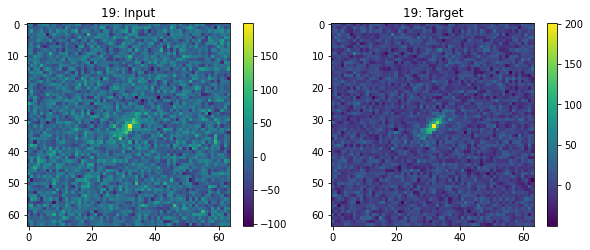

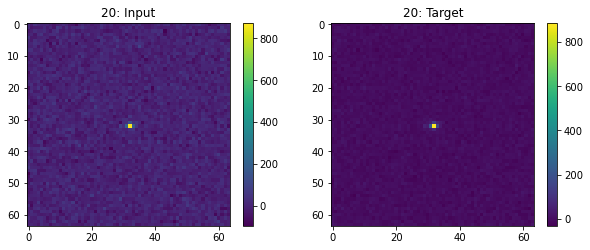

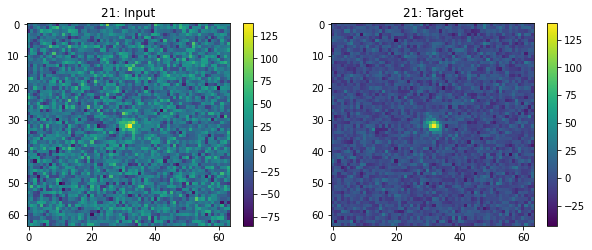

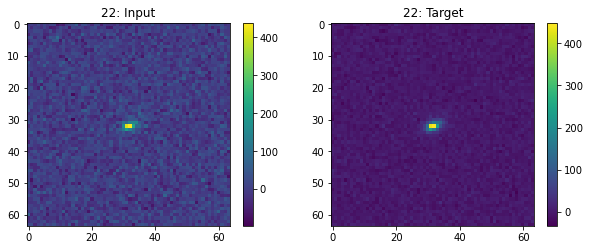

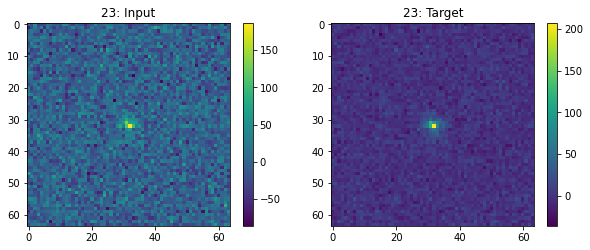

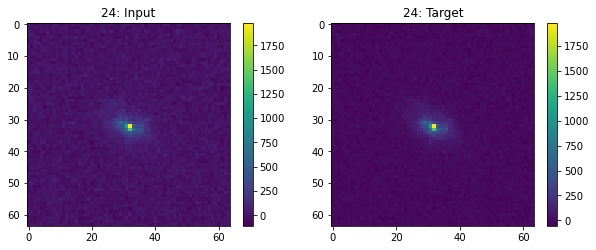

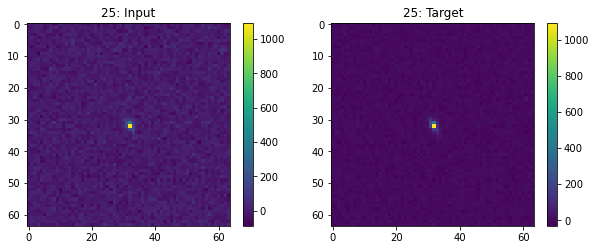

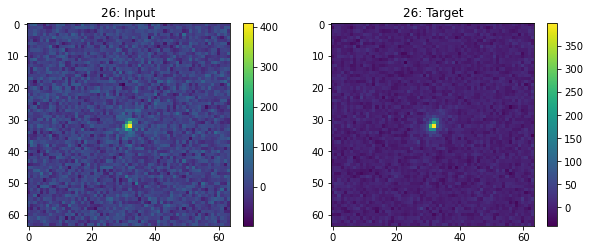

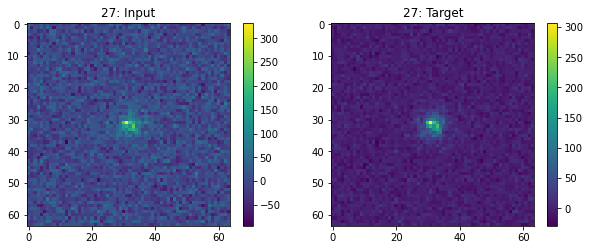

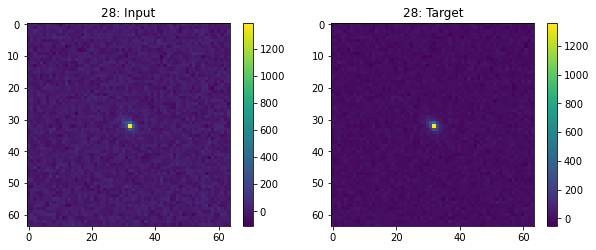

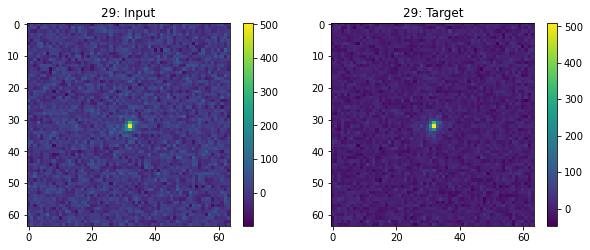

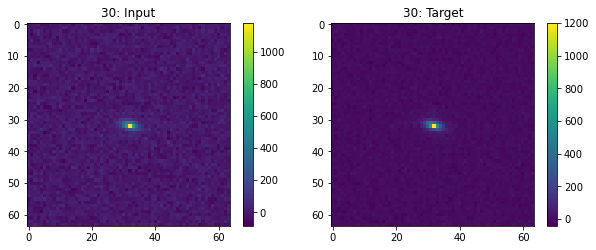

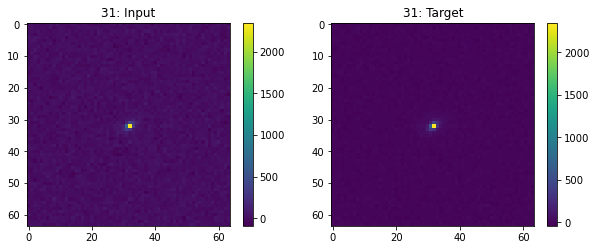

In [4]:
# Load images from the batch

for ind in range(n_batch):
    plt.figure(figsize=(10,10))
    plt.subplot(121)
    plt.imshow(batch[0][ind])
    plt.title('{}: Input'.format(ind))
    plt.colorbar(shrink=0.3725)
    plt.subplot(122)
    plt.imshow(batch[1][ind])
    plt.title('{}: Target'.format(ind))
    plt.colorbar(shrink=0.3725)
    plt.show()

### U-Net

In [5]:
def DenseBlock(n_layers, n_kernels, input_layer, activation_function='swish',
               axis_concat=3, concat_input=True,dilation_rate=1):
    
    #concat_input: implies that we have a skip concatenation between input and output of block
    connect_input = input_layer
    
    for n in range(n_layers):
        
        bn = tf.keras.layers.BatchNormalization()(connect_input)
        act = tf.keras.layers.Activation(activation_function)(bn)
        conv = tf.keras.layers.SeparableConv2D(n_kernels, 3, padding='same', use_bias=False,
                                               kernel_initializer='he_uniform')(act)
        if n == 0:
            concat = conv
        else:
            concat = tf.keras.layers.Concatenate(axis = axis_concat)([concat, conv])
        
        connect_input = concat
        
    if concat_input:
        return tf.keras.layers.Concatenate(axis = axis_concat)([input_layer, concat])
    
    return concat


# Define the modified U-net
img_rows = img_cols = 64
nb_scales = 4
growth_rate = 12
nb_layers_per_block = [4,5,6,7]
activation_function= 'relu'
gamma=1


# NETWORK CONSTRUCTION STARTS HERE
inputs = tf.keras.Input(shape=[img_rows, img_cols, 1])


# INPUT CONV
net = tf.keras.layers.Conv2D(32, 3, padding='same', use_bias=False, kernel_initializer='he_uniform')(inputs)


# CONTRACTING PATH
skip_connect = []

for scale in range(nb_scales-1):
    
    block = DenseBlock(n_layers=nb_layers_per_block[scale],
                       n_kernels=growth_rate,
                       input_layer=net,
                       activation_function=activation_function,
                       concat_input=True)
    
    skip_connect.append(block)
    batch_norm = tf.keras.layers.BatchNormalization()(block)
    activation = tf.keras.layers.Activation(activation_function)(batch_norm)
    
    conv_transi = tf.keras.layers.Conv2D(32+np.sum(nb_layers_per_block[:scale+1])*growth_rate, 1, padding='same', 
                                         use_bias=False, kernel_initializer='he_uniform')(activation)
    
    net = tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='same')(conv_transi)

    
# BOTTLENECK
block = DenseBlock(n_layers=nb_layers_per_block[-1],
                   n_kernels=growth_rate,
                   input_layer=net,
                   activation_function=activation_function,
                   concat_input=False)


#EXPANSIVE PATH
for scale in range(nb_scales-2, -1, -1):   
    
    up = tf.keras.layers.Conv2D(nb_layers_per_block[scale+1]*growth_rate, 2, activation = activation_function,
             padding = 'same', kernel_initializer = 'he_normal')(tf.keras.layers.UpSampling2D(size = (2,2))(block))
    
    net = tf.keras.layers.Concatenate(axis = 3)([up, skip_connect[scale]])
    
    block = DenseBlock(n_layers=nb_layers_per_block[scale],
                       n_kernels=growth_rate,
                       input_layer=net,
                       activation_function=activation_function,
                       concat_input=False)

    
# FUSION AND SKIP CONNECT
batch_norm = tf.keras.layers.BatchNormalization()(block)
activation = tf.keras.layers.Activation(activation_function)(batch_norm)
outputs = tf.keras.layers.Conv2D(1, 1, activation = 'linear')(activation)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


### Compile the model

In [6]:
model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer = tf.keras.optimizers.Adam(lr=1e-3), loss = 'mse', metrics=['accuracy'])

In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 32)   288         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 64, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 64, 64, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [8]:
history = model.fit(dset, steps_per_epoch=6250, epochs=10)

Train on 6250 steps
Epoch 1/10
6250/6250 [==============================] - 904s 145ms/step - loss: 563.7839 - acc: 0.0000e+00
Epoch 2/10
6250/6250 [==============================] - 902s 144ms/step - loss: 164.2354 - acc: 0.0000e+00
Epoch 3/10
6250/6250 [==============================] - 909s 145ms/step - loss: 117.4378 - acc: 0.0000e+00
Epoch 4/10
6250/6250 [==============================] - 902s 144ms/step - loss: 107.5163 - acc: 0.0000e+00
Epoch 5/10
6250/6250 [==============================] - 908s 145ms/step - loss: 105.6752 - acc: 0.0000e+00
Epoch 6/10
6250/6250 [==============================] - 900s 144ms/step - loss: 103.4217 - acc: 0.0000e+00
Epoch 7/10
6250/6250 [==============================] - 907s 145ms/step - loss: 103.9063 - acc: 0.0000e+00
Epoch 8/10
6250/6250 [==============================] - 900s 144ms/step - loss: 101.7170 - acc: 0.0000e+00
Epoch 9/10
6250/6250 [==============================] - 906s 145ms/step - loss: 100.9466 - acc: 0.0000e+00
Epoch 10/10
6250/

In [9]:
model.save('Models/UNet_basic')

### Results

dict_keys(['loss', 'acc'])


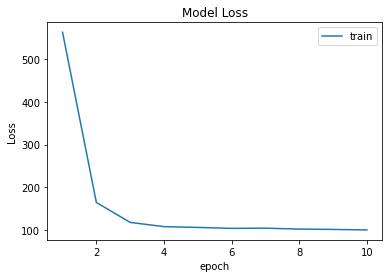

In [10]:
print(history.history.keys())

plt.plot(range(1,11), history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train'])
plt.show()

In [11]:
# The model can be applied like so
res = model(batch[0].astype('float32'))

# This should return the solution of the denoising problem
res_np = tf.keras.backend.eval(res).squeeze(axis=-1)  

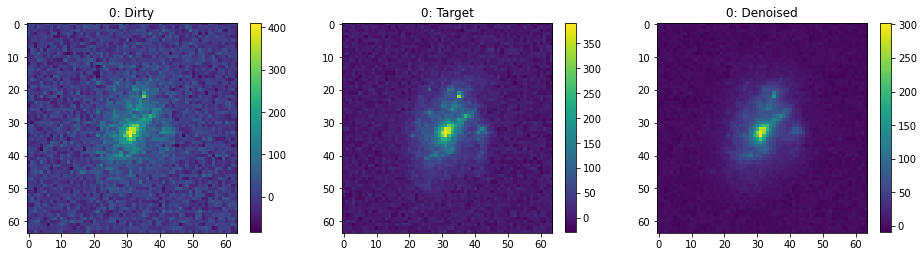

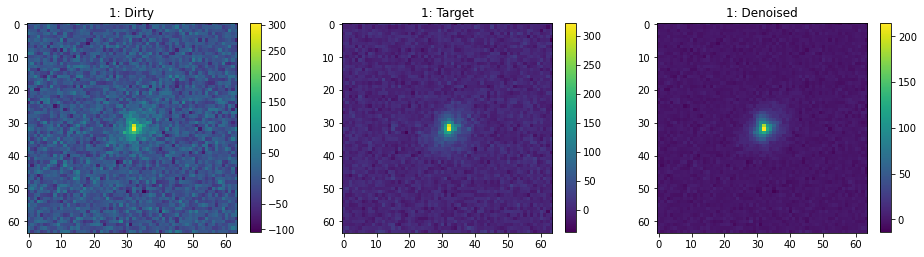

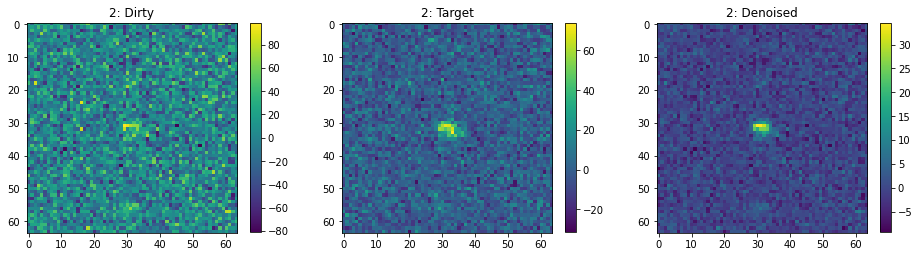

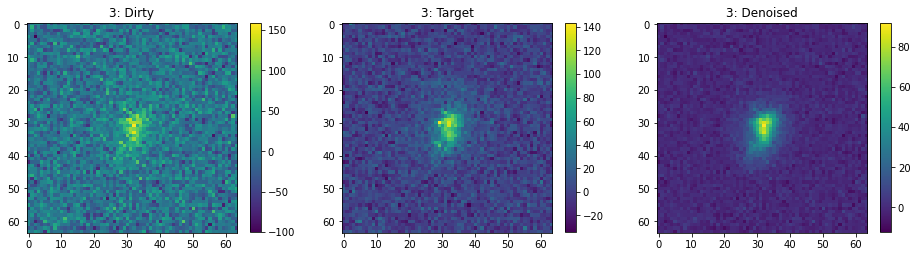

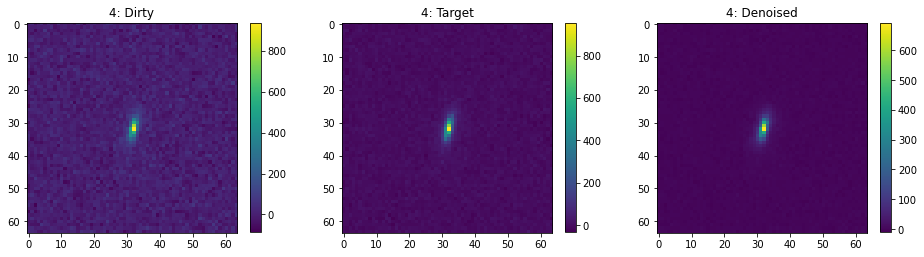

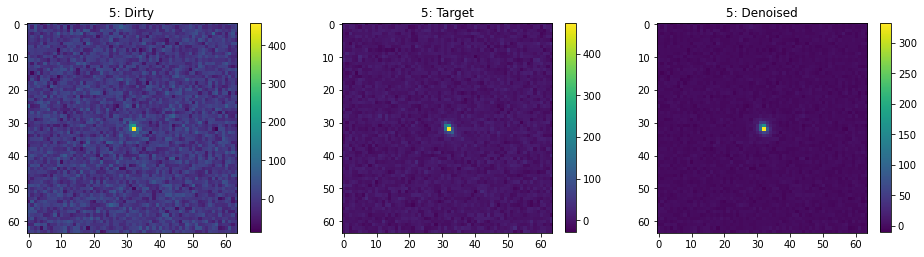

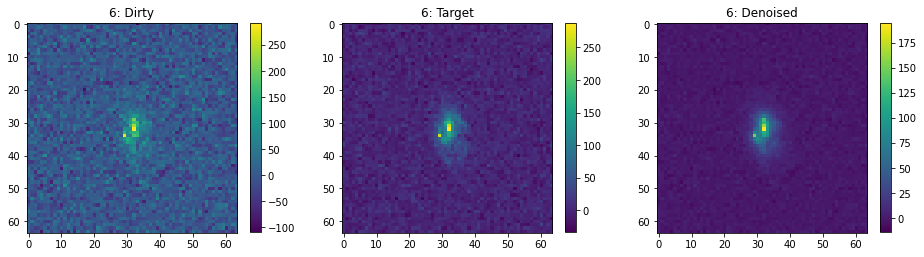

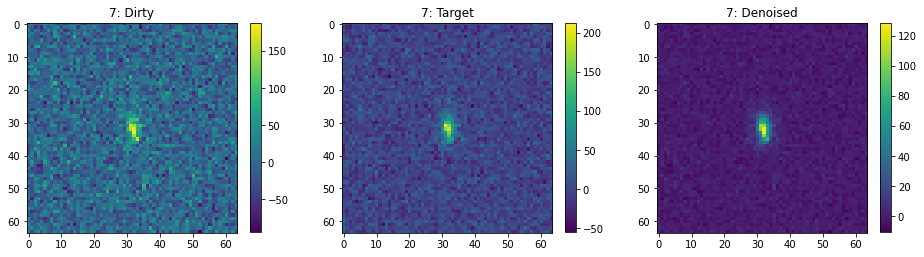

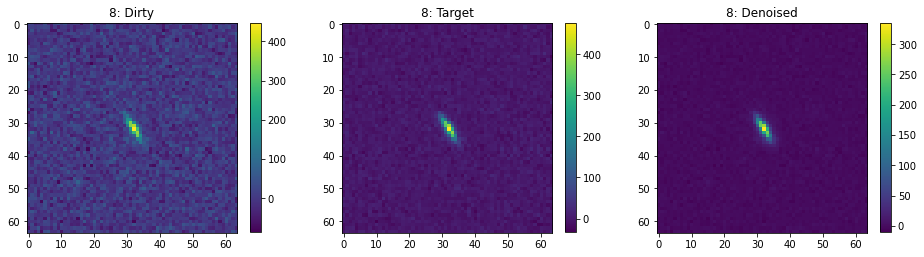

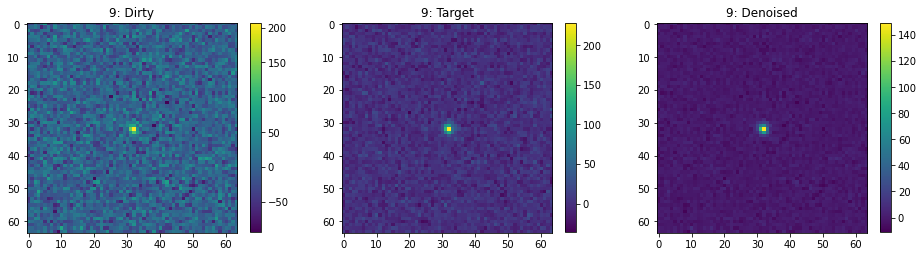

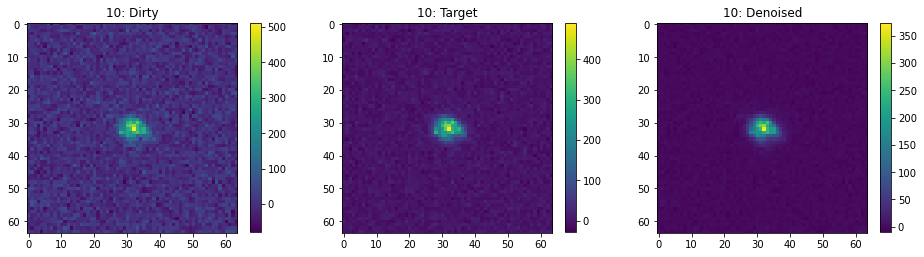

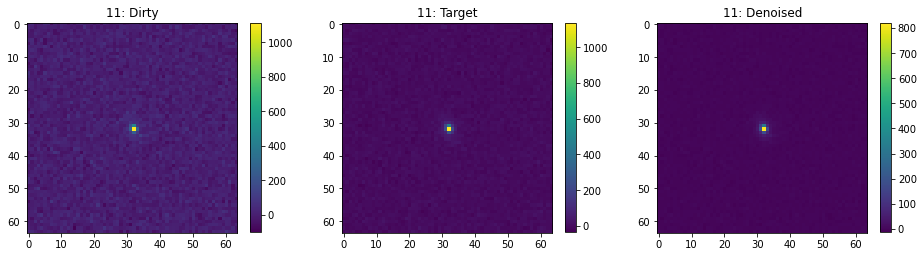

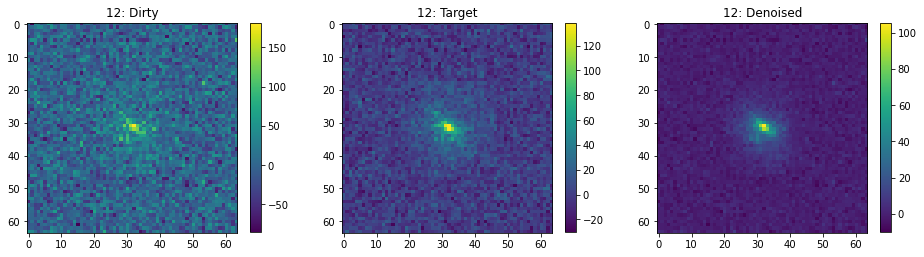

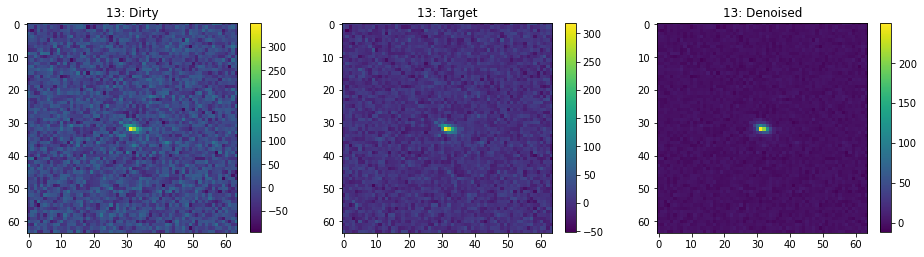

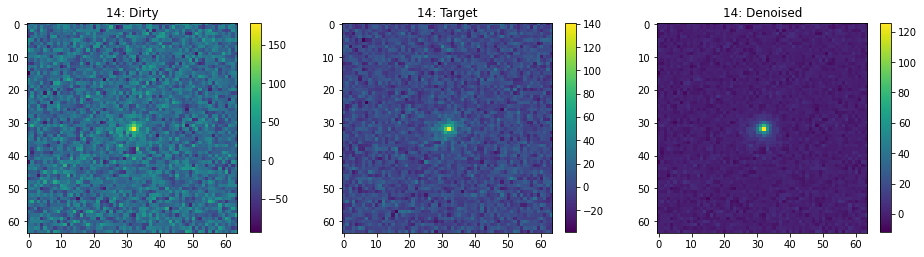

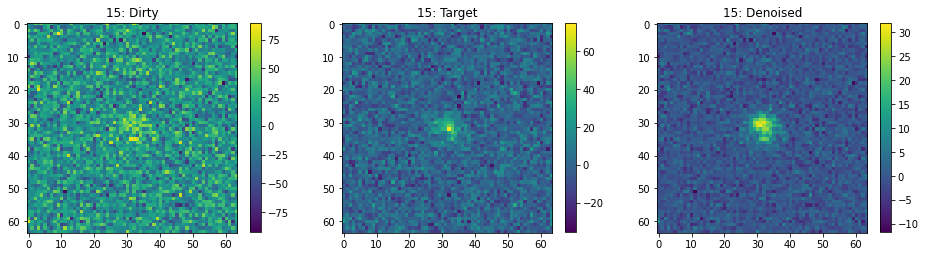

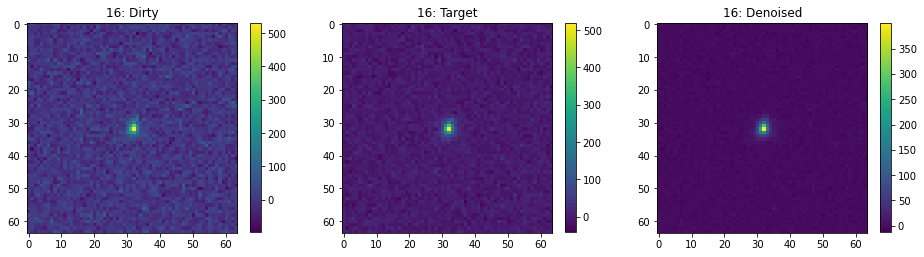

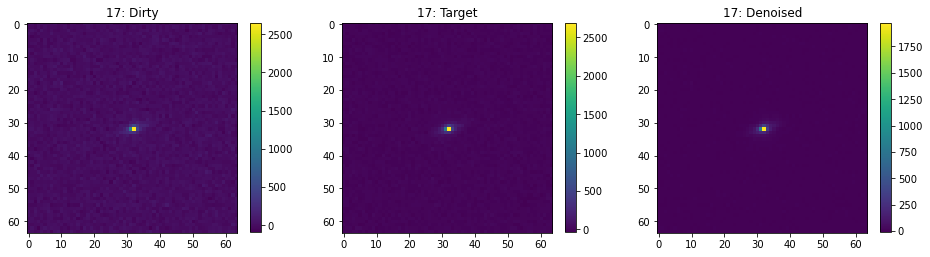

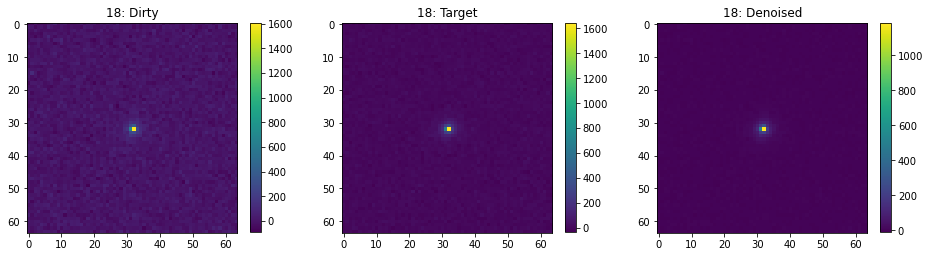

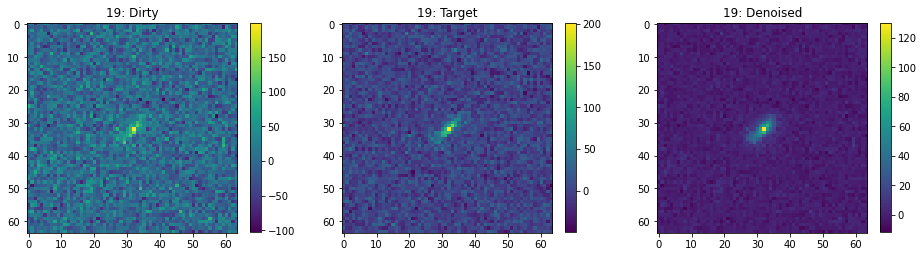

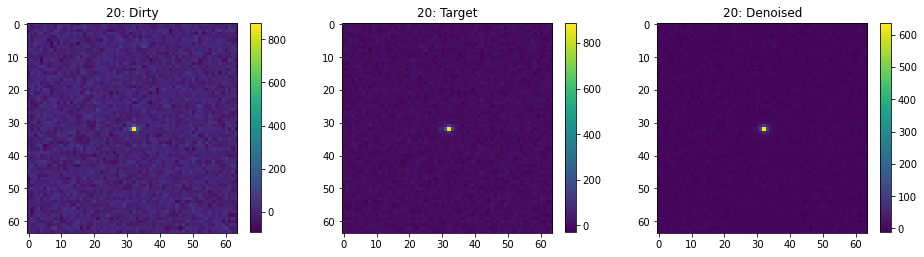

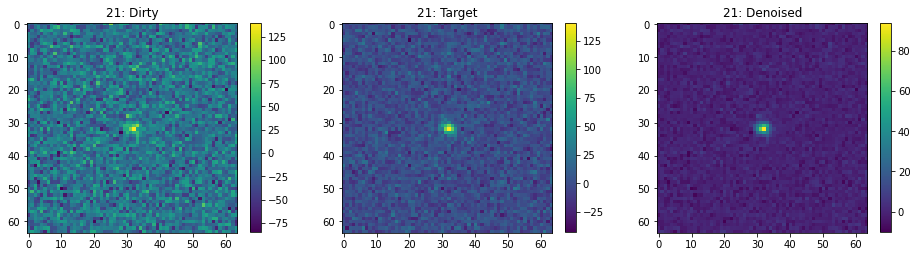

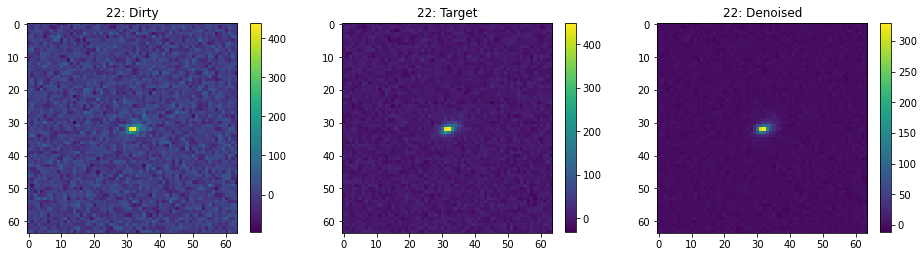

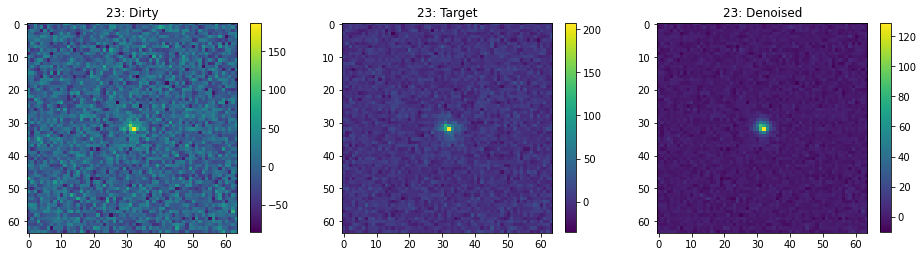

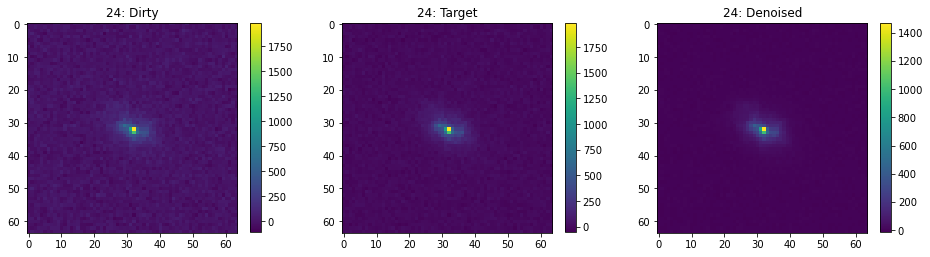

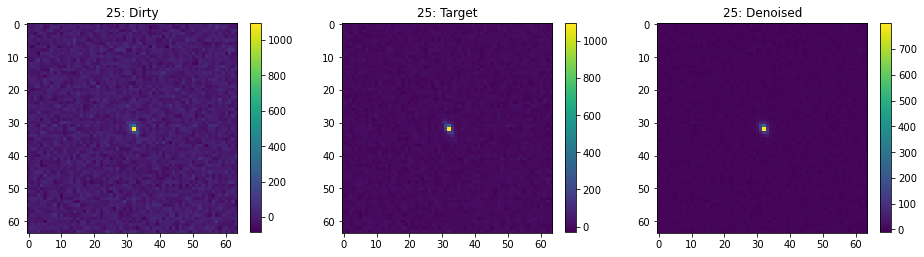

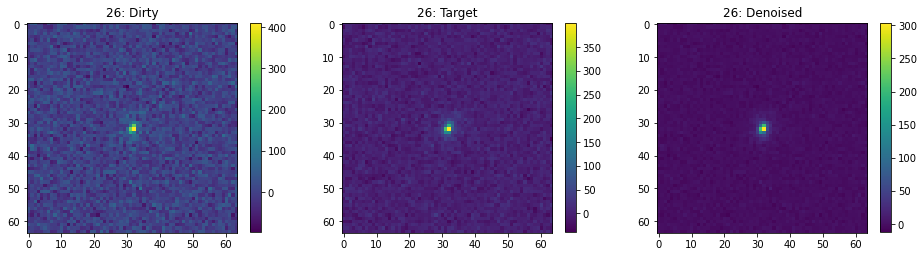

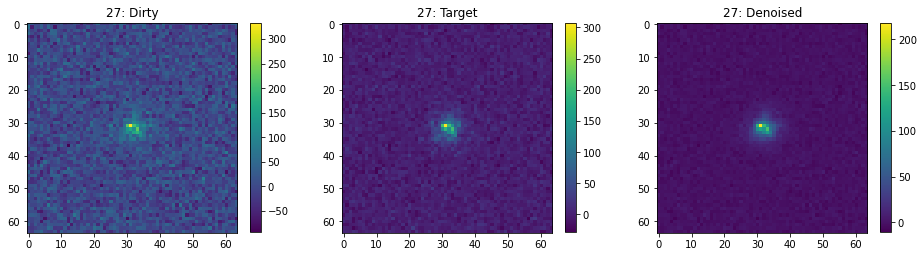

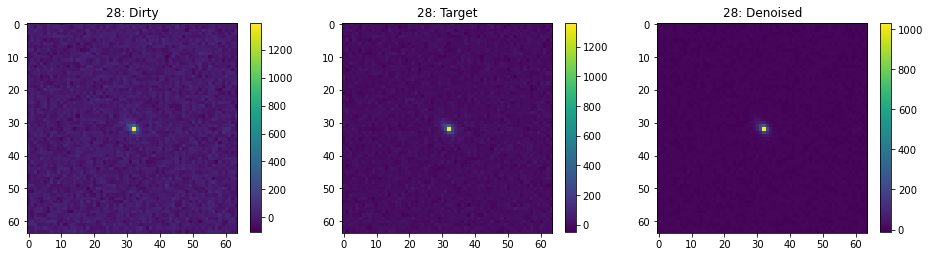

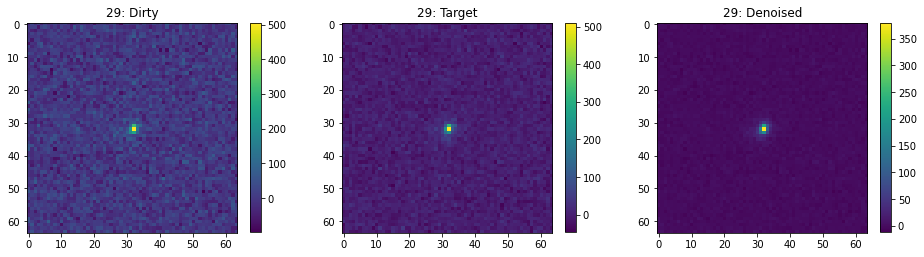

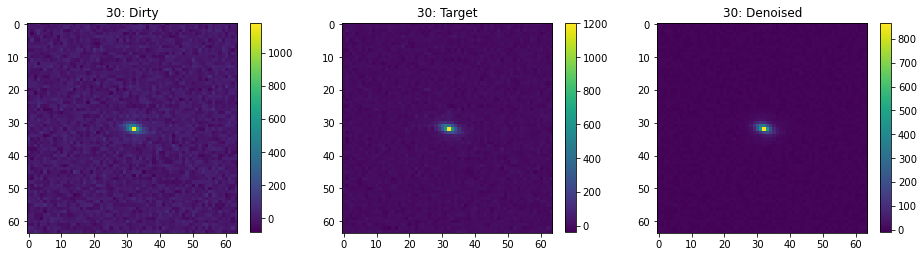

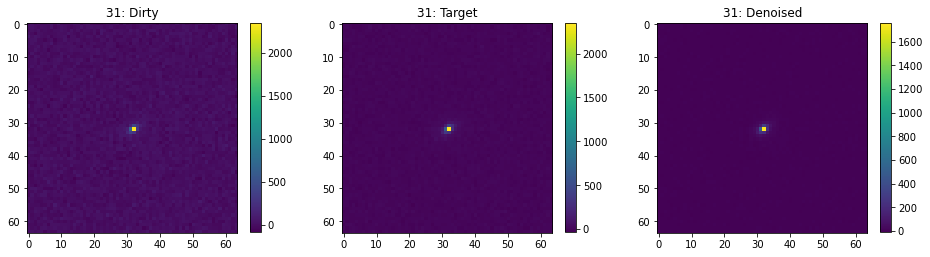

In [12]:
# Look at a few results

for index in range(n_batch):
    fig = plt.figure(figsize=(16,16))
    plt.subplot(131)
    plt.imshow(batch[0][index].squeeze(axis=-1))
    plt.title('{}: Dirty'.format(index))
    plt.colorbar(shrink=0.24)
    plt.subplot(132)
    plt.imshow(batch[1][index].squeeze(axis=-1))
    plt.title('{}: Target'.format(index))
    plt.colorbar(shrink=0.24)
    plt.subplot(133)
    plt.imshow(res_np[index])
    plt.title('{}: Denoised'.format(index))
    plt.colorbar(shrink=0.24)
    plt.show(fig)    